# Analysing census data 

We collect some crime and census data and create a model to try to explain the variations in crime

## Import libraries and read the data

Import libraries

In [4]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
#import geoplot
#import geoplot.crs
from sklearn import linear_model
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression

import shapefile as shp  # pip install pyshp 

Read the data. We use crime data downloaded from [data.police.uk](https://data.police.uk/).

In [10]:
# D2022 is the crime data from 2022.
i = 2
D2022 = pd.read_csv("./2022-0"+str(1)+"/2022-0"+str(1)+"-west-yorkshire-street.csv")
while(i < 10):
    dTem = pd.read_csv("./2022-0"+str(i)+"/2022-0"+str(i)+"-west-yorkshire-street.csv")
    D2022 = pd.concat([D2022,dTem])
    i += 1
D2022

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,b51a8ffcf605789c6be9cd07c97311b8b1faaa0ce0d96c...,2022-01,West Yorkshire Police,West Yorkshire Police,-1.570572,53.607792,On or near Park/Open Space,E01007418,Barnsley 016A,Theft from the person,Investigation complete; no suspect identified,NaN
1,acb6f40266da318fd82bd4265396c6c2e5cd7e0cabf37b...,2022-01,West Yorkshire Police,West Yorkshire Police,-1.879031,53.943807,On or near Cross End Fold,E01010646,Bradford 001A,Other theft,Unable to prosecute suspect,NaN
2,f78e6a11150e94af881cbdf31ba9533dae26cd8ca361c6...,2022-01,West Yorkshire Police,West Yorkshire Police,-1.879031,53.943807,On or near Cross End Fold,E01010646,Bradford 001A,Violence and sexual offences,Unable to prosecute suspect,NaN
3,NaN,2022-01,West Yorkshire Police,West Yorkshire Police,-1.881808,53.942344,On or near Stockinger Lane,E01010647,Bradford 001B,Anti-social behaviour,NaN,NaN
4,c69a2ecce06027e30f547c841abc0ee0ce8beb603720eb...,2022-01,West Yorkshire Police,West Yorkshire Police,-1.884392,53.944378,On or near George Street,E01010648,Bradford 001C,Burglary,Investigation complete; no suspect identified,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
25110,fac88572b4e8eed2f9367ebd304833bf11973a8072128c...,2022-02,West Yorkshire Police,West Yorkshire Police,NaN,NaN,No Location,NaN,NaN,Other crime,Unable to prosecute suspect,NaN
25111,75373e7637913ff4628b3d13189a495baaf596b553828f...,2022-02,West Yorkshire Police,West Yorkshire Police,NaN,NaN,No Location,NaN,NaN,Other crime,Status update unavailable,NaN
25112,38b661c7349207e3187891e9eedba76c122fdf1346ce95...,2022-02,West Yorkshire Police,West Yorkshire Police,NaN,NaN,No Location,NaN,NaN,Other crime,Court result unavailable,NaN
25113,848013e744fa11b0d7e8eaa051d5423e6e93e805d93674...,2022-02,West Yorkshire Police,West Yorkshire Police,NaN,NaN,No Location,NaN,NaN,Other crime,Investigation complete; no suspect identified,NaN


<AxesSubplot:xlabel='Crime type'>

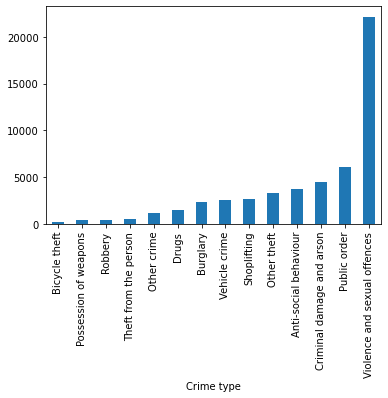

In [11]:
# Distributio by crime type 
crTp = D2022.pivot_table(columns = "Crime type", aggfunc = "size")
crTp = crTp.sort_values()
crTp.plot.bar()

<AxesSubplot:>

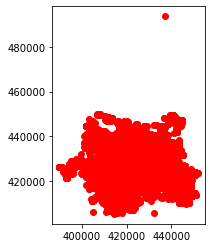

In [12]:
# Locations of crimes
gdf = gpd.GeoDataFrame(
    D2022, geometry=gpd.points_from_xy(D2022.Longitude, D2022.Latitude), crs = "EPSG:4326")
gdf = gdf.to_crs("EPSG:27700")

gdf.plot(color = "red")

Read LSOA data

In [36]:
shpPath = os.path.join(".","LSOA","england_lsoa_2011_sgen_clipped.shp")

sf = shp.Reader(shpPath)
def read_shapefile(sf):
#fetching the headings from the shape file
    fields = [x[0] for x in sf.fields][1:]
#fetching the records from the shape file
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
#converting shapefile data into pandas dataframe
    df = pd.DataFrame(columns=fields, data=records)
#assigning the coordinates
    df = df.assign(coords=shps)
    return df

df = read_shapefile(sf)

<AxesSubplot:>

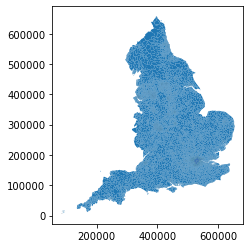

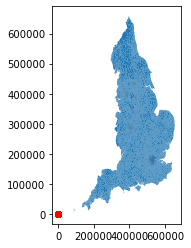

In [37]:
# Read the LSOA data and plot the LSOAs and crimes
Lshape = gpd.read_file(shpPath)
Lshape.plot()
ax = Lshape.plot()
gdf.plot(ax=ax, color = "red")

In [38]:
# Project both datasets to WGS
Lshape = Lshape.to_crs("EPSG:4326")
gdf = gdf.to_crs("EPSG:4326")

In [39]:
Lshape

,name,code,geometry
0,North East Lincolnshire 013B,E01013150,"POLYGON ((-0.13613 53.55644, -0.14296 53.56239..."
1,Swindon 007D,E01015580,"POLYGON ((-1.78573 51.57653, -1.78730 51.57494..."
2,North Hertfordshire 010A,E01023601,"POLYGON ((-0.27428 51.94900, -0.27521 51.95345..."
3,Dover 005B,E01024217,"POLYGON ((1.40258 51.23871, 1.39306 51.23363, ..."
4,Bromley 023A,E01000722,"POLYGON ((0.11461 51.39255, 0.11472 51.39192, ..."
...,...,...,...
32839,Newcastle upon Tyne 024B,E01008395,"POLYGON ((-1.62374 54.97508, -1.62788 54.97482..."
32840,Westminster 024E,E01004739,"POLYGON ((-0.13750 51.48565, -0.13776 51.48632..."
32841,Hammersmith and Fulham 023E,E01032789,"POLYGON ((-0.18096 51.47384, -0.18187 51.47265..."
32842,Newcastle upon Tyne 024A,E01008394,"POLYGON ((-1.62406 54.98370, -1.62357 54.98205..."


In [40]:
# Remove the crimes that are a long way north from West Yorkshire
gdf = gdf.loc[gdf.Latitude<54.2]

Need to count the number of crimes in each LSOA. 

In [41]:
# Spatial join LSOAs to points (will end up with one row for each point)
joined = Lshape.sjoin(gdf)

# In 'joined', each area is repeated 'n' times, where 'n' is the number of crimes in that area
# Each area has a unique code ('code')
# To to count the number of crimes per area, we can count the number of times each 'code' appears
num_crimes = joined.groupby('code').count()

# Jon this count back to the LSOAs data
Lshape = Lshape.merge(num_crimes.geometry.rename('n_points').reset_index(), left_on="code", right_on="code")

<AxesSubplot:>

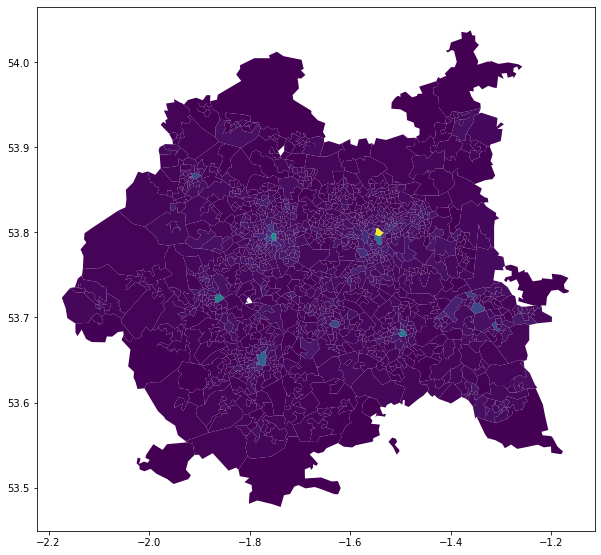

In [42]:
Lshape.plot(column="n_points", figsize=(10,10))

In [43]:
Lshape

,name,code,geometry,n_points
0,Kirklees 011F,E01011166,"POLYGON ((-1.67461 53.71525, -1.67019 53.71417...",43
1,Leeds 015A,E01011556,"POLYGON ((-1.52237 53.85581, -1.52428 53.85046...",18
2,Leeds 024C,E01011652,"POLYGON ((-1.51761 53.84131, -1.51571 53.84878...",16
3,Leeds 103A,E01011307,"POLYGON ((-1.37254 53.75608, -1.35458 53.75124...",32
4,Bradford 001D,E01010692,"POLYGON ((-1.83706 53.93137, -1.84058 53.92802...",50
...,...,...,...,...
1391,Wakefield 022D,E01011921,"POLYGON ((-1.52696 53.67833, -1.52866 53.67819...",44
1392,Wakefield 019A,E01011920,"POLYGON ((-1.50036 53.68581, -1.49766 53.68267...",143
1393,Bradford 047A,E01010633,"POLYGON ((-1.80066 53.78985, -1.80275 53.78718...",29
1394,Bradford 016C,E01010571,"POLYGON ((-1.77527 53.83778, -1.77754 53.84195...",62


Read the census data

In [44]:
cenData = pd.read_csv("./2011_Census_Data.csv")

In [45]:
cenData

,SOA Code,SOA Name,LA Code,Local Authority Name,Supergroup Code,Supergroup Name,Group Code,Group Name,% Persons living in a communal establishment,Number of persons per heactre,...,% Employed persons aged between 16 and 74 who work in the wholesale and retail trade; repair of motor vehicles and motor cycle vehicles,% Employed persons aged between 16 and 74 who work in the transport or service industries,% Employed persons aged between 16 and 74 who work in the accommodation or food service activities industries,"% Employed persons aged between 16 and 74 who work in the informatiojn and communication or professional, scientific and technical acitivities industries","% Employed persons aged between 16 and 74 who work in the financial, insurance or real estate industries`",% Employed persons aged between 16 and 74 who work in the administrative or support service activities industries,% Employed persons aged between 16 and 74 who work in the public administration or defence; compulsory or social security industries,% Employed persons aged between 16 and 74 who work in the education sector,% Employed persons aged between 16 and 74 who work in the human health and social work activities industries,Unnamed: 68
0,E01020723,County Durham 029C,E06000047,County Durham,1.0,Cosmopolitan student neighbourhoods,1a,Cosmopolitan student neighbourhoods,0.1,48.7,...,12.2,2.0,7.4,11.8,2.3,4.0,6.4,25.7,8.5,NaN
1,E01020703,County Durham 030A,E06000047,County Durham,1.0,Cosmopolitan student neighbourhoods,1a,Cosmopolitan student neighbourhoods,5.3,57.4,...,11.8,0.9,18.6,9.8,2.2,2.0,4.9,30.6,8.0,NaN
2,E01033164,County Durham 030D,E06000047,County Durham,1.0,Cosmopolitan student neighbourhoods,1a,Cosmopolitan student neighbourhoods,56.0,41.0,...,10.0,0.7,17.5,11.3,2.9,2.0,2.7,28.6,7.7,NaN
3,E01033195,County Durham 030E,E06000047,County Durham,1.0,Cosmopolitan student neighbourhoods,1a,Cosmopolitan student neighbourhoods,31.2,32.0,...,6.6,1.7,12.6,8.3,2.7,3.2,4.6,35.0,11.2,NaN
4,E01033197,County Durham 030F,E06000047,County Durham,1.0,Cosmopolitan student neighbourhoods,1a,Cosmopolitan student neighbourhoods,43.7,32.8,...,8.7,2.2,26.1,4.8,3.1,3.6,9.0,24.6,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42774,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
#renaming to match the columns
cenData = cenData.rename(columns = {"SOA Code": "code"})

Merge the census data and the LSOA data

In [47]:
result = pd.merge(Lshape, cenData, on = "code", how = "left")

<AxesSubplot:>

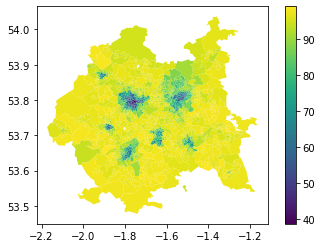

In [50]:
# Plot a variable to check the join worked
result.plot("% Persons whose country of birth is the United Kingdom or Ireland", legend = True)

## Modelling

Now we have a big table ('result') with a load of census variables and a crime count. We would like to explore the relationship between the census variables and crime using statistical models. We will use a linear regression to start with, but could use other models as well

Begin by preparing the explanatory data (the variables `X`) and the dependent data (crimes, `Y`)

In [51]:
#DataFrame with features, independent variable
X = result.iloc[0:1412,11:71]
#Series with number of crimes, dependent variable
Y = result["n_points"]

In [52]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

LinearRegression()

In [56]:
regr.coef_

array([  1.37041535,  -0.27414713,  -2.99892717,  -3.73344591,
        -2.78966155,  -3.06537793,  -3.83919798,  -8.86620045,
        -1.76593757,  -0.53525452,   1.68916262, -17.8094378 ,
       -18.40645958, -17.42162659, -17.74326274, -17.44118797,
       -14.26274935, -18.06992942, -13.80238427,   0.95837979,
         1.63460897,   6.71062353,  -4.00099391,   0.16559917,
        -0.79212836,   0.3991171 ,  -0.22555606,  -0.11022737,
        -0.10015517,   0.16327092,  -4.03221383,  -4.21466554,
        -4.97104315,   1.53428384,   0.08226183,   0.10313833,
        -0.30471821,  -5.64223149,  -1.89324651,   1.3249394 ,
         0.46152577,  -1.14822707,  -2.00772998,  -0.99185587,
         1.14729575,  56.05390036,  57.03391026,  -6.66614438,
        -2.35304071,  -1.5118323 ,  -1.69193892,  -1.21144287,
        -3.22577635,   0.52279269,  -1.15924379,   0.77573105,
        -4.12878236,  -1.02988116,  -1.85952098,  -1.1415766 ])

There are so many census variables it is hard to make sense of the model. Lets try to find the variables that have the greatest impact on the crime count.

In [55]:
#Select top k features based on mutual info regression
selector = SelectKBest(mutual_info_regression, k = 5)
selector.fit(X, Y)
X.columns[selector.get_support()]

Index(['% Persons aged 16 and over who are single',
       '% Persons aged 16 and over who are married or registered in a civil partnership',
       '% Households who own or have shared ownership of property',
       '% Households with two or more cars',
       '% Employed persons aged between 16 and 74 who are unemployed'],
      dtype='object')

In [57]:
# Fit the model to those features (columns)
regr.fit(result[X.columns[selector.get_support()]], Y)

LinearRegression()

In [58]:
# Check the R2 score (1.0=perfect, 0.0=rubbish)
regr.score(X[X.columns[selector.get_support()]], Y)

0.18853415739253387

The $R^2$ score of 0.19 is not very good. Lets add some more features. But how many? It would be good to get an idea about how the error ($R^2$) changes as we add features so we can decide at what point we're happy with the combination of fewest features and highest $R^2$).

In [61]:
#cols_index = result.columns.get_indexer(X.columns[selector.get_support()])

In [64]:
# Iteratively increase the number of features to be considered by the Selector and
# store the R2 score each time
arr = []
seq = []
i = 2
while(i <= 60):
        selector = SelectKBest(mutual_info_regression, k = i)
        selector.fit(X, Y)
        regr.fit(result[X.columns[selector.get_support()]], Y)
        arr.append(regr.score(X[X.columns[selector.get_support()]], Y))
        if(i%2 == 0): seq.append(i)
        i += 1
ser = pd.Series(arr, copy = False)

<AxesSubplot:title={'center':'PP-feature_number relation'}, xlabel='Number of features', ylabel='Prediction power'>

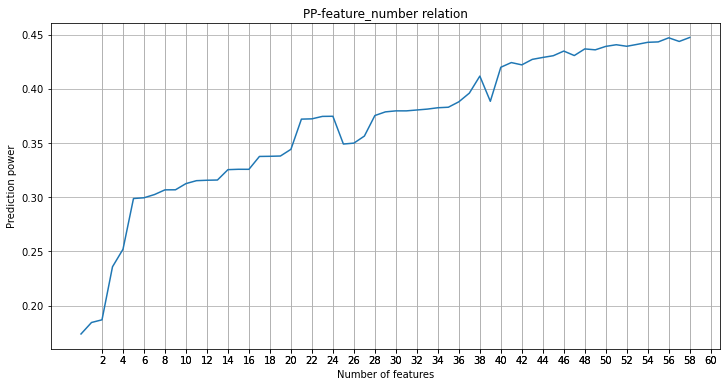

In [72]:
ser.plot(figsize = (12, 6), fontsize = 10, ylabel = "Prediction power", xlabel = "Number of features", grid = "True", xticks = seq*2, title = "PP-feature_number relation")

To do:

 [ ] Do the above a number of times (10 times) so we can see get an idea for how much the error varies each time

Have a look at the columns that give the best error repeatedly

In [73]:
t = 10
maxx = 0
bestR = pd.DataFrame()
for i in range(20):
    #seq = []
    
    selector = SelectKBest(mutual_info_regression, k = t)
    selector.fit(X, Y)
    regr.fit(result[X.columns[selector.get_support()]], Y)
    scr = regr.score(X[X.columns[selector.get_support()]], Y)
    if(scr > maxx): maxx = scr; bestR = result[X.columns[selector.get_support()]]
    #if(i%2 == 0): seq.append(i)

bestR.columns

,% Persons aged 16 and over who are single,% Persons aged 16 and over who are married or registered in a civil partnership,% Persons whose country of birth is the new EU (post 2004 accession countries),% Households who live in a detached house or bungalow,% Households who own or have shared ownership of property,% Occupancy room rating one or less rooms than required,% Households with two or more cars,% Persons aged between 16 and 74 who use private transport transport to get to work,"% Persons aged between 16 and 74 who walk, cycle or use an alternative method of transport to get to work",% Employed persons aged between 16 and 74 who are unemployed
0,34.9,47.2,1.1,21.0,61.7,12.2,23.4,72.6,13.2,5.2
1,35.7,47.3,2.2,12.8,63.4,5.7,27.0,71.1,6.4,3.9
2,34.1,51.7,0.7,9.6,78.8,4.4,46.5,69.8,9.0,2.0
3,30.5,46.7,0.3,6.8,69.2,5.2,28.9,73.8,8.1,4.9
4,22.6,55.5,0.8,23.2,79.8,4.7,39.5,58.7,10.6,1.7
...,...,...,...,...,...,...,...,...,...,...
1391,29.3,51.8,1.4,14.0,71.2,4.9,30.6,73.9,13.2,4.2
1392,43.8,28.2,5.9,5.9,48.7,11.5,18.1,46.8,33.0,4.4
1393,30.1,52.2,1.0,26.2,75.0,6.7,33.2,74.7,7.9,4.1
1394,39.3,37.9,2.2,4.8,63.0,10.0,22.5,68.5,11.5,6.2


<AxesSubplot:title={'center':'PP-feature_number relation'}, xlabel='Number of features', ylabel='Prediction power'>

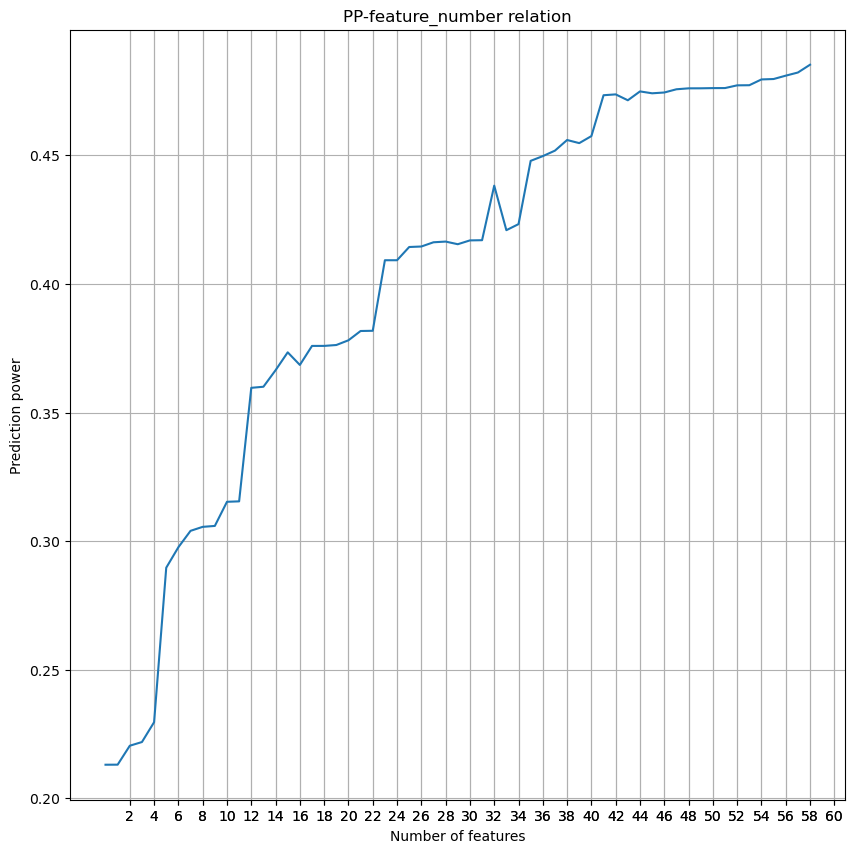